In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 4000
pd.options.display.max_columns
pd.options.display.float_format = '{:.3f}'.format 
np.set_printoptions(suppress=True, precision=5)

import warnings
warnings.filterwarnings("ignore")

In [59]:
#https://phamdinhkhanh.github.io/2020/01/17/ScoreCard.html#23-ti%C3%AAu-chu%E1%BA%A9n-m%C3%B4-h%C3%ACnh-scorecard

In [2]:
#import
df = pd.read_csv(r'E:\learn st new\Credit score\loan_data_pd_modeling.csv', low_memory= False)
df.head()

,grade_A,grade_B,grade_D,grade_E,grade_G,term_60,verification_status_Verified,verification_status_Not Verified,purpose_small_business,purpose_debt_medical,...,"total_rec_int_(2277.758, 4555.516]","total_rec_int_(4555.516, 13666.548]","total_rec_int_(15944.306, 18222.064]","total_rec_int_(13666.548, 15944.306]","total_rec_int_(18222.064, 22777.58]","total_rec_late_fee_(-0.359, 35.868]","total_rec_late_fee_(35.868, 143.472]","total_rec_late_fee_(143.472, 215.208]","total_rec_late_fee_(215.208, 358.68]",loan_crt_score
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [3]:
input =df.drop(columns = 'loan_crt_score')
output = df['loan_crt_score']

In [4]:
#Scale dữ liệu cột out_prncp
from sklearn.preprocessing import MinMaxScaler

df_scaled = MinMaxScaler().fit_transform(df[['out_prncp','loan_crt_score']])
df_scaled = pd.DataFrame(df_scaled, columns = ['out_prncp','loan'])
input['out_prncp'] = df_scaled.loc[:, 'out_prncp']

In [5]:
#Chia train -test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.2)

#kết quả
print("Variables in Train Set : {} & Test Set : {}".format(len(x_train), len(x_test)))
y_train.value_counts()

Variables in Train Set : 190128 & Test Set : 47532


1    148925
0     41203
Name: loan_crt_score, dtype: int64

In [6]:
# Xử lý imbalance
from imblearn.over_sampling import RandomOverSampler

X_train_o, y_train_o = RandomOverSampler().fit_resample(x_train, y_train)
y_train_series = pd.Series(y_train_o)

y_train_series.value_counts()

0    148925
1    148925
Name: loan_crt_score, dtype: int64

## PD Model
---

In [7]:
#PD model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_o, y_train_o)

LogisticRegression()

In [ ]:
# Hệ số b0 của mô hình
model.intercept_

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve

# Dự đoán mô hình
y_preds = model.predict(x_test)
#classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.58      0.90      0.70     10373
           1       0.97      0.82      0.88     37159

    accuracy                           0.83     47532
   macro avg       0.77      0.86      0.79     47532
weighted avg       0.88      0.83      0.85     47532



### Nhận xét
- Đối với phân loại là 0, recall = 0.9 => Số credit tốt bị lọt lưới = 1 mỗi 10
- Độ chính xác của mô hình đạt 83% => Mô hình phân loại có hiệu quả

In [16]:
#tạo đầu vào cho Roc-auc curve
y_hat_test_proba = model.predict_proba(x_test)
y_hat_test_proba = y_hat_test_proba[:][: , 1]
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba), pd.DataFrame(y_preds)], axis = 1)
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba', 'y_hat_test']
y_test_proba.index = x_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba,y_hat_test
207976,1,0.210,0
147881,1,0.998,1
219384,1,0.996,1
174282,1,0.999,1
63111,1,1.000,1


Hệ số gini của mô hình là 0.89


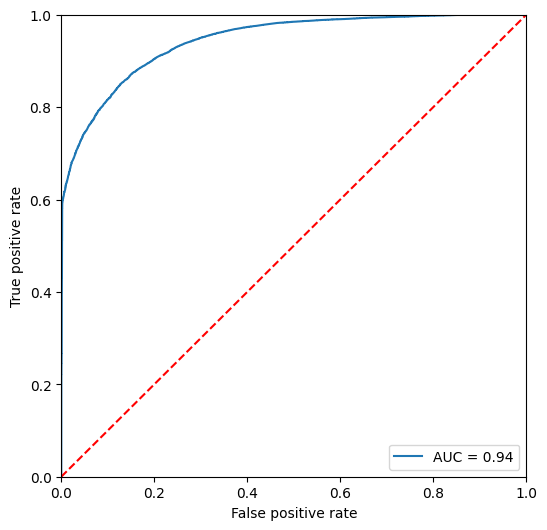

In [17]:
# get the values required to plot a ROC curve
import sklearn.metrics as metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
roc_auc = metrics.auc(fpr, tpr)
# roc_curve n gini
Gini_index = round((2* roc_auc -1),2)
print('Hệ số gini của mô hình là {}'.format(Gini_index))

plt.figure(figsize = (6, 6))
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc =  'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


### Nhận xét:
- Mô hình có hệ số gini cao = 0.88 và AUC = 94% có nghĩa mô hình phân loại là tốt

TÍnh điểm Scorecard
---
$$
Credit Score = (beta \cdot WOE + \frac{alpha}{n}) \cdot Factor + \frac{Offset}{n}
$$

Note:
- $ Odds =  1:50 $
- $ Base_score = 600 $
- $ pdo \space là\space mức\space điểm\space để \space gấp \space đôi \space odds (mặc \space định = 20) $
- $ Factor = \frac{pdo}{ln(2)} $
- $ Offset = Base_score - Factor \cdot ln(Odds) $